# Stock prediction using news sentiment analysis and stock history 

<a href="https://colab.research.google.com/gist/ashwinkey04/de066da294792f198b7f74ad6ec702e8/fyp_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import datetime
import datetime

# Get the time and print it
datetime.datetime.now()
print('Notebook last run: ',datetime.datetime.now())## Dataset Format


Notebook last run:  2023-03-17 08:25:38.229715


## Dataset Format




> Gathering news articles and stock prices for a specific stock and preparing the dataset for sentiment analysis and stock value prediction


#### How it works
> This notebook fetches daily stock market data of a specified stock from [yfinance](https://www.yahoofinanceapi.com/) api and its daily news articles from [mediastack](https://mediastack.com/) api and creates a derived dataset which contains **news sentiment**. This notebook can be scheduled to run daily on Google Cloud Run to gather data daily




#### stock_history.csv 

1. Date - Trading date
2. Open - Open price of day
3. High - Highest price of day
4. Low - Lowest price of day
5. Close - Closing price of day
6. Volume - Amount of asset/security 
7. Dividends - Distribution of stock
8. Stock splits - Shares of stock to its current shareholders


#### news.json

1. author - author of news article 
2. title - title of news article 
3. description - description of news article
4. url - url of news article
5. source - source of news article
6. image - image of news article
7. category - category of news article
8. language - language of news article
9. country - country name
10. published_at - published date

#### news_sentiment.csv

1. published_at - published date
2. title - title of news article 
3. description - description of news article
4. url - url of news article
5. sentiment - news sentiment
6. sentiment_score - news sentiment score between 0 to 1



## Installing packages


In [2]:
# Install Yahoo Finance package
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install Google cloud helper package
%pip install firebase-admin

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Install Transformers package for transfer learning
%pip install transformers

#Install pmdarima package for ARIMA
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Importing packages

In [5]:
# Optional: To fix descriptors not found error in transformers package
# %pip install grpcio-status==1.33.2 protobuf==3.19.6

In [3]:
# Import libraries 
import yfinance as yf
import pandas as pd
import numpy as np
import os
import json
from datetime import date,timedelta, datetime
import warnings
import http.client, urllib.parse

warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
#Disabling warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
from datetime import datetime

import urllib3
from xml.dom.minidom import parseString
import requests


In [6]:
### Importing packages
import itertools
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Define parameters

In [7]:
# Data start date
start_date = '2018-03-14'

# company symbol and name

company_symbol="RELIANCE.NS"
company_name="Reliance"

# company_symbol="INFY.NS"
# company_name="Infosys"

# company_symbol="KOTAKBANK.BO"
# company_name="Kotak Bank"

# company_symbol="TSLA"
# company_name="Tesla"

# company_symbol="GOOG"
# company_name="Google"

In [8]:
config_json = './pred-fyp-firebase-adminsdk-r0whj-703d889b60.json'

#Get mediastack API key from json
with open(config_json, 'r+') as file:
    data = json.load(file)

#secret key of mediastack api
mediastack_api_token = data['mediastack']

In [9]:
#Initialise today date
today = str(date.today())
yesterday = str(date.today()- timedelta(days = 1))
start_date = '2018-03-14'


# input file paths
stock_history_file_path='./input/{}_stock_history.csv'.format(company_name)
news_file_path='./input/{}_news.json'.format(company_name)
news_sentiment_file_path='./input/{}_news_sentiment.csv'.format(company_name)

# output file paths
output_stock_history_file_path='./{}_stock_history.csv'.format(company_name)
output_news_file_path='./{}_news.json'.format(company_name)
output_news_sentiment_file_path='./{}_news_sentiment.csv'.format(company_name)

# parameters for mediastack api
search_query=company_name
conn = http.client.HTTPConnection('api.mediastack.com')
def get_news_params(offset):
    return urllib.parse.urlencode({
    'keywords': search_query,
    'access_key': mediastack_api_token,
    'sort': 'published_desc',
    'offset': offset,
    'limit': 100,
    'languages': 'en',
    })

http_pm = urllib3.PoolManager()


In [10]:
def reformat_date(input_dt_str):
    # Parse input datetime string to datetime object
    input_dt = datetime.strptime(input_dt_str, "%a %d %b %Y %H:%M:%S %Z")
    # Convert datetime object to output string format
    return input_dt.strftime("%Y-%m-%dT%H:%M:%S+00:00")

### Connect to Google Cloud backend

In [11]:
# Authenticate with Google Cloud using a service account private key
import firebase_admin
from firebase_admin import credentials, firestore, storage

firebase_admin._apps={}
cred = credentials.Certificate(config_json)
default_app = firebase_admin.initialize_app(cred,  {'storageBucket': 'pred-fyp.appspot.com'})

In [12]:
firebase_admin._apps.values()
# firebase_admin.delete_app(default_app)

dict_values([<firebase_admin.App object at 0x7fab1ed42c10>])

In [13]:
# Connect to the database
db = firestore.client()

# Connect to the storage bucket
bucket = storage.bucket(name='pred-fyp.appspot.com')

In [158]:
# Download all files from the storage bucket
blobs = bucket.list_blobs()
for blob in blobs:
    blob.download_to_filename(blob.name)

## Fetch stock history from Yahoo

In [14]:
ticker_object=yf.Ticker(company_symbol)

def create_stock_history_dataset():
    fin_stock_history=ticker_object.history(period="5y").reset_index()
    return fin_stock_history

def update_stock_history_dataset():
    fin_stock_history=pd.read_csv(stock_history_file_path)
    fin_stock_history.Date=pd.to_datetime(fin_stock_history.Date, format='%Y/%m/%d')
    today_fin_stock_data=ticker_object.history(period="3d")
    today_fin_stock_data=today_fin_stock_data.reset_index()
    last_stock_date=str(today_fin_stock_data.loc[0,'Date']).split()[0]
    if last_stock_date == fin_stock_history['Date'].dt.strftime('%Y-%m-%d')[len(fin_stock_history)-1]: #if already inserted 
        fin_stock_history.iloc[-1:,:]=today_fin_stock_data.iloc[-1].tolist()
    else:
        last_position=len(fin_stock_history)
        fin_stock_history.loc[last_position]=today_fin_stock_data.iloc[-1].tolist()
    return fin_stock_history

In [15]:
# create stock market history dataset
ticker_object=yf.Ticker(company_symbol)
if os.path.exists(stock_history_file_path)==False:
    fin_stock_history=create_stock_history_dataset()
else:
    fin_stock_history=update_stock_history_dataset()

# Rename Stock Splits column to Stock_Splits
fin_stock_history.rename(columns={'Stock Splits':'Stock_Splits'},inplace=True)

fin_stock_history.to_csv(output_stock_history_file_path,index=False)

## Create/Update news dataset

#### Utility functions for fetching datasets

In [16]:
#### Scraping news from Google News

def get_google_news_scraped_results(query, start_date, end_date):
    url = "https://news.google.com/rss/search?q={}%20after%3A{}%20before%3A{}&hl=en-US&gl=US&ceid=US:en&count=100".format(query, start_date, end_date)
    response = http_pm.request('GET', url)
    dom = parseString(response.data)
    items = dom.getElementsByTagName('item')
    news_list = []
    for item in items:
        # Assign title to variable
        title = item.getElementsByTagName('title')[0].firstChild.nodeValue.replace(',', ' ').replace('\'', ' ')
        link = item.getElementsByTagName('link')[0].firstChild.nodeValue
        description = title
        pubDate = item.getElementsByTagName('pubDate')[0].firstChild.nodeValue.replace(',', ' ')

        # Reformat date to existing format
        pubDate = reformat_date(pubDate)
        news_list.append({'title': title, 'description': description, 'url': link, 'published_at': pubDate})
    return news_list

In [17]:
def sort_news_by_date(file_path):
    with open(file_path, 'r+') as file:
        data = json.load(file)
    sorted_articles = sorted(data['articles'], key=lambda x: x['published_at'])

    # print the sorted list of dictionaries
    # print(json.dumps({'articles': sorted_articles}, indent=2))

    data['articles'] = sorted_articles
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=2)
    print('Sorted {} by date'.format(file_path))


In [18]:
#Append results to a list called articles in an existing json news_articles json file
def add_results_to_news_json(new_data, filename=output_news_file_path):
    with open(filename,'r+') as file:
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["articles"].extend(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [19]:
# Remove duplicate news articles inside articles list from output news json file
def remove_duplicate_news_articles(filename=output_news_file_path):
    with open(filename, 'r+') as file:
        data = json.load(file)
    articles = data['articles']
    articles = [dict(t) for t in {tuple(d.items()) for d in articles}]
    data['articles'] = articles
    with open(filename, 'w') as file:
        json.dump(data, file, indent=2)
    print('Removed duplicate news articles from {}'.format(filename))

#### Fetch recent news from mediastack

In [20]:
def create_news_dataset():
    global res
    print('Creating news dataset')
    conn.request('GET', '/v1/news?{}'.format(get_news_params(0)))
    res = conn.getresponse().read()
    jsonres = json.loads(res.decode('utf-8'))
    fin_news= jsonres["data"]

    #Implementing pagination to get all the available news
    if jsonres["pagination"]["count"] < jsonres["pagination"]["total"]:
        for i in range(100,jsonres["pagination"]["total"],100):
            conn.request('GET', '/v1/news?{}'.format(get_news_params(i)))
            res = conn.getresponse().read()
            jsonres = json.loads(res.decode('utf-8'))
            fin_news+=jsonres["data"]
    return fin_news

def update_news_dataset():
    global news_inserted
    news_inserted=False

    with open(output_news_file_path,'r') as file:
        fin_news=json.load(file)
        for news in fin_news['articles']:
            if news['published_at'].split('T')[0]==yesterday:
                news_inserted=True
                break
        current_fin_news=None
        if news_inserted==False:
            conn.request('GET', '/v1/news?{}'.format(get_news_params(0)))
            res = conn.getresponse().read()
            current_fin_news=json.loads(res.decode('utf-8'))["data"]
            fin_news['articles']+=current_fin_news
        return fin_news['articles'],current_fin_news

In [21]:
#create news dataset 
if os.path.exists(output_news_file_path)==False:
    fin_news=create_news_dataset()
    current_fin_news=fin_news.copy()
else:
    fin_news,current_fin_news=update_news_dataset()

with open(output_news_file_path,'w') as file:
    json.dump({"articles":fin_news},file)

#### Scraping news data older than one year

In [22]:
# Sort news by date
sort_news_by_date(output_news_file_path)

# Load news json
with open(output_news_file_path,'r') as file:
    fin_news=json.load(file)

news_start_date = (fin_news['articles'][0]['published_at'].split('T')[0])
news_start_date

Sorted ./Reliance_news.json by date


'2018-03-14'

In [23]:
loop_start_date = start_date

while (loop_start_date<news_start_date):
    end_date = str(date.fromisoformat(loop_start_date)+ timedelta(days=30))
    print('',loop_start_date, end_date)
    
    # Get news results from Google News
    news_list = get_google_news_scraped_results(search_query, start_date, end_date) 
    
    #Create new news json file
    if os.path.exists(output_news_file_path)==False:
        with open(output_news_file_path, 'w') as file:
            json.dump({'articles': news_list}, file, indent=2)
    else:
        #Add results to existing news json file
        add_results_to_news_json(news_list) 
    loop_start_date = end_date

#### Clean up news dataset

In [24]:
remove_duplicate_news_articles()

Removed duplicate news articles from ./Reliance_news.json


In [25]:
sort_news_by_date(output_news_file_path)

Sorted ./Reliance_news.json by date


## Predict sentiment on articles


In [26]:
# Load pretrained FinBERT model from Hugging Face

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [27]:
# Load fin_news from json file in case of fresh run
with open(output_news_file_path, 'r') as file:
    fin_news = json.load(file)['articles']

In [28]:
def create_news_sentiment_dataset(news_sentiments):
    last_position=len(news_sentiments)
    article_ind=last_position
    title_description=[]
    if (current_fin_news!=None) or (current_fin_news==None and os.path.exists(output_news_sentiment_file_path)==False):
        if(current_fin_news!=None):
            print('Current News not empty')
            article_list_for_sentiment = current_fin_news
        else:
            article_list_for_sentiment = fin_news
        for article in article_list_for_sentiment:
            title_description.append(article['title']+' '+article['description'])
            news_sentiments.at[article_ind,'published_at']=article['published_at']
            news_sentiments.at[article_ind,'title']=article['title']
            news_sentiments.at[article_ind,'description']=article['description']
            news_sentiments.at[article_ind,'url']=article['url']
            article_ind+=1
        news_label_and=classifier(list(title_description))
        labels=[pred['label'] for pred in news_label_and]    
        scores=[pred['score'] for pred in news_label_and]
        news_sentiments.loc[last_position:,'sentiment']=labels
        news_sentiments.loc[last_position:,'sentiment_score']=scores

    news_sentiments.to_csv(output_news_sentiment_file_path,index=None)  

## Add news sentiment

In [29]:
news_sentiments=None
if os.path.exists(output_news_sentiment_file_path):
    news_sentiments=pd.read_csv(output_news_sentiment_file_path,index_col=None)                     
else:
    news_sentiments=pd.DataFrame(columns=['published_at','title','description','url','sentiment','sentiment_score'])
create_news_sentiment_dataset(news_sentiments)

### Join news sentiment scores to Stock history

In [30]:
if('positive_sentiment' not in fin_stock_history.columns):
    fin_stock_hist_len = len(fin_stock_history)
    fin_stock_history['positive_sentiment'] = np.empty((fin_stock_hist_len, 0)).tolist()
    fin_stock_history['negative_sentiment'] = np.empty((fin_stock_hist_len, 0)).tolist()
    fin_stock_history['neutral_sentiment'] = np.empty((fin_stock_hist_len, 0)).tolist()
    fin_stock_history.tail()

In [31]:
fin_stock_history.set_index('Date', inplace=True)

In [32]:
def assign_score(date, sentiment, score):
    sentiment+= '_sentiment'
    #Check if date exists in stock history
    if date in fin_stock_history.index:
        fin_stock_history.at[pd.to_datetime(date),sentiment].append(score)

In [33]:
# Iterate through news sentiments and assign scores to stock history
for i,r in news_sentiments.iterrows():
    date = r['published_at'].split('T')[0]
    sentiment = r['sentiment']
    score = r['sentiment_score']
    assign_score(date, sentiment, score)

In [34]:
fin_stock_history = fin_stock_history.reset_index()
fin_stock_history.to_csv(output_stock_history_file_path,index=False)

### Update news sentiment on DB and Storage bucket


In [35]:
recent_news_sentiments = news_sentiments.tail(20).copy()

# Retain only date from published_at
recent_news_sentiments['published_at'] = recent_news_sentiments['published_at'].apply(lambda x: x.split('T')[0])
recent_news_sentiments = recent_news_sentiments.loc[::-1].reset_index(drop=True)


In [36]:
sentiment_coll = db.collection('news_sentiments')

fin_doc_ref = sentiment_coll.document(u'{}'.format(company_symbol))

In [37]:
if fin_doc_ref.get().exists == False:
    # Create documennt if it doesn't exist
    fin_doc_ref.set({
        'news_sentiments': (recent_news_sentiments.to_dict('records'))
    })
else:
    #Update DB with predicted sentiment
    fin_doc_ref.update({
        'news_sentiments': (recent_news_sentiments.to_dict('records'))
    })


In [38]:
# Upload generated files to bucket
stock_blob = bucket.blob(output_stock_history_file_path)
stock_blob.upload_from_filename(output_stock_history_file_path)

news_blob = bucket.blob(output_news_file_path)
news_blob.upload_from_filename(output_news_file_path)

news_sentiment_blob = bucket.blob(output_news_sentiment_file_path)
news_sentiment_blob.upload_from_filename(output_news_sentiment_file_path)


## ARIMA 

### Importing packages and preparing dataframe

In [39]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [40]:
try: 
    dateparse = lambda dates: pd.datetime.strptime(dates.split()[0], '%Y-%m-%d')
    stock_data = pd.read_csv(output_stock_history_file_path, index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
except Exception as e:
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
    stock_data = pd.read_csv(output_stock_history_file_path, index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [41]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock_Splits,positive_sentiment,negative_sentiment,neutral_sentiment
Date,,,,,,,,,,
2018-03-19,873.435875,879.155382,864.711233,868.104126,5829127,0.0,0.0,[],[],"[0.9281095862388612, 0.8758390545845032, 0.934..."
2018-03-20,865.971444,876.344121,859.912617,862.578491,7011559,0.0,0.0,[0.9453160762786864],[0.8563583493232727],"[0.8434631824493408, 0.9447512626647948, 0.680..."
2018-03-21,867.474007,874.744551,865.971410,869.461243,6791028,0.0,0.0,[],[],"[0.7686998248100281, 0.930237889289856, 0.5450..."
2018-03-22,868.588792,884.050839,868.346473,880.367126,10212863,0.0,0.0,[],[],[]
2018-03-23,863.353967,872.466427,861.899870,866.553040,10831400,0.0,0.0,[],[],"[0.708733320236206, 0.9338114857673644, 0.8849..."


### Stationarize data
Before using the ARIMA model, we have to ensure that our data is stationarized. For a data to be stationarized:

1. The mean of the series should not be a function of time.
2. The variance of the series should not be a function of time.
3. the covariance of the i th term and the (i + m) th term should not be a function of time.


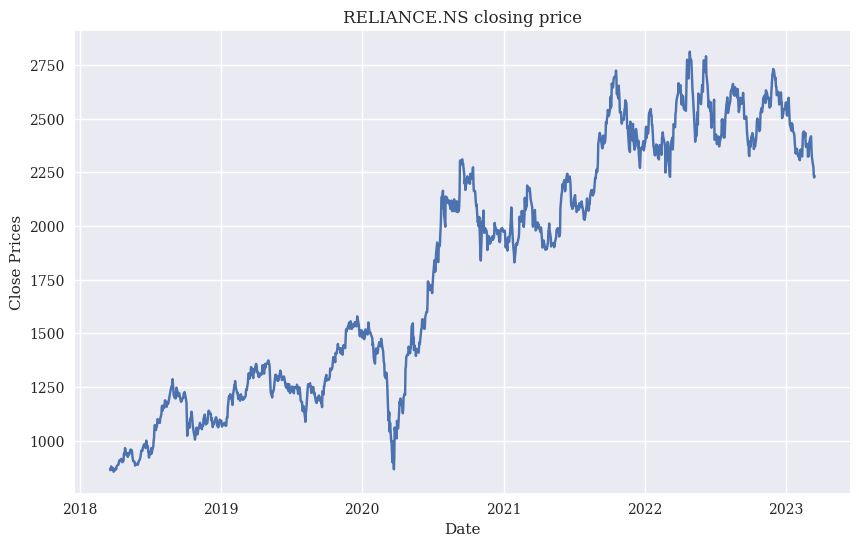

In [42]:
#Plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('{} closing price'.format(company_symbol))
plt.show()

<Axes: ylabel='Density'>

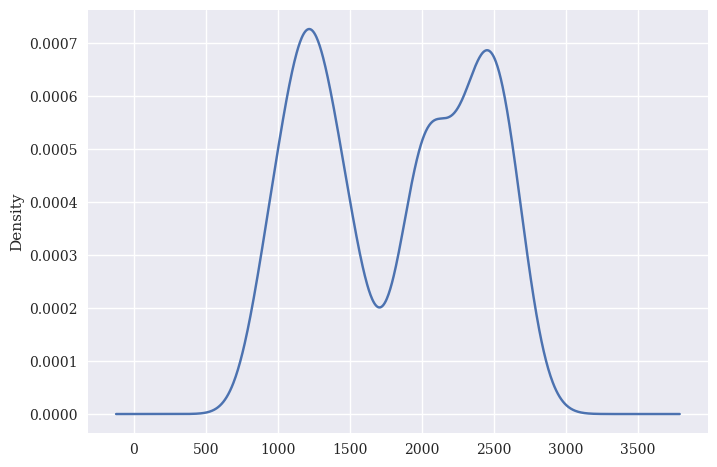

In [43]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

#### ADF (Augmented Dickey-Fuller) Test
ADF is used to determine whether the series has a unit root or not, therefore determining if series is stationary or not


- **Null Hypothesis**: The series has a unit root (value of a =1)
- **Alternate Hypothesis**: The series has no unit root.

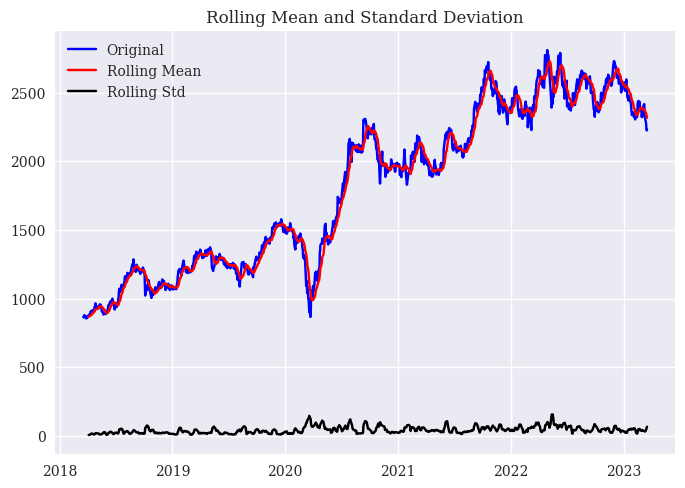

Results of dickey fuller test
Test Statistics                  -1.546174
p-value                           0.510559
No. of lags used                  0.000000
Number of observations used    1236.000000
critical value (1%)              -3.435652
critical value (5%)              -2.863881
critical value (10%)             -2.568016
dtype: float64



In [44]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output,end ='\n\n')
test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


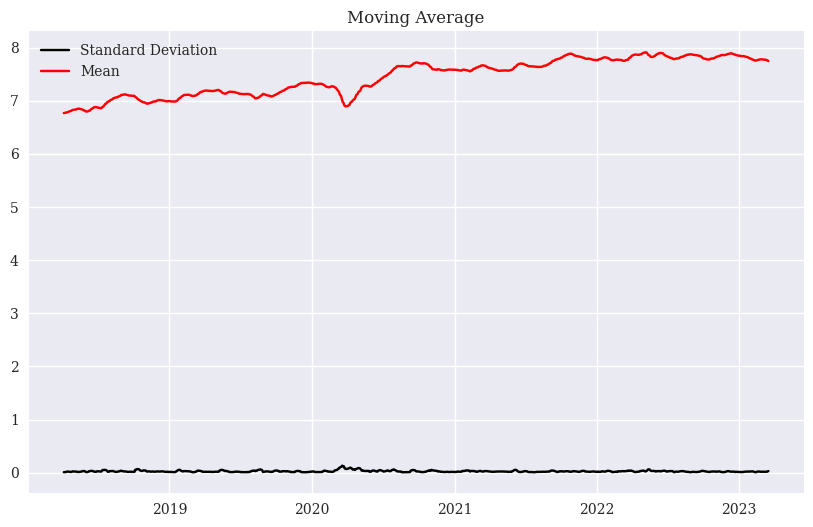

In [45]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### Train model with best *p,d,q* parameters

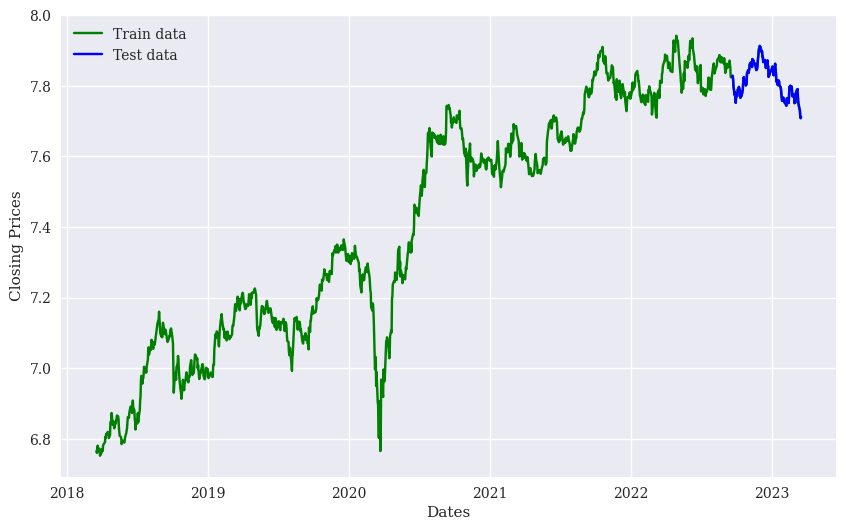

In [46]:
# Split data into train and test
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-2661.839, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-4974.775, Time=1.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-3662.326, Time=1.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-2634.788, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-4731.279, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-5084.834, Time=3.97 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.52 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-2662.727, Time=1.66 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-5083.086, Time=5.45 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-5083.078, Time=5.15 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-3668.043, Time=3.57 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-5081.556, Time=5.59 sec
 ARIMA(1,0,0)(2,1,0)[12

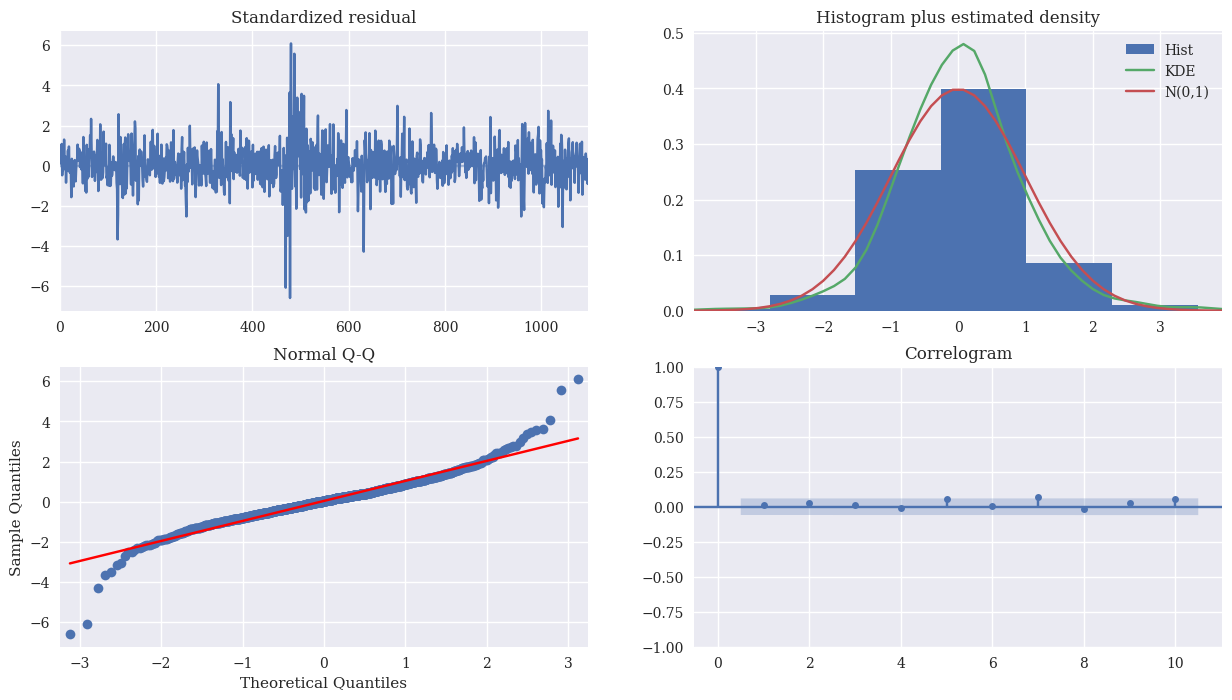

In [47]:
# Use auto_arima to find the best AR,I, and MA parameters for our model
stepwise_fit = auto_arima(train_data, start_p = 1, start_q = 1,
                            max_p = 3, max_q = 3, m = 12,
                            start_P = 0, seasonal = True,
                            d = None, D = 1, trace = True,
                            error_action ='ignore',
                            suppress_warnings = True,
                            stepwise = True)

print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [51]:
# Build Model
model = ARIMA(train_data, order=stepwise_fit.order)
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  865
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4187.332
Date:                Fri, 17 Mar 2023   AIC                           8380.663
Time:                        08:28:59   BIC                           8394.952
Sample:                             0   HQIC                          8386.132
                                - 865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1521.9622    465.418      3.270      0.001     609.760    2434.165
ar.L1          0.9987      0.002    449.338      0.000       0.994       1.003
sigma2       931.5680     24.085     38.678      0.0

/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
train_data, test_data = df_close[0:int(len(df_close)*0.7)], df_close[int(len(df_close)*0.7):]
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

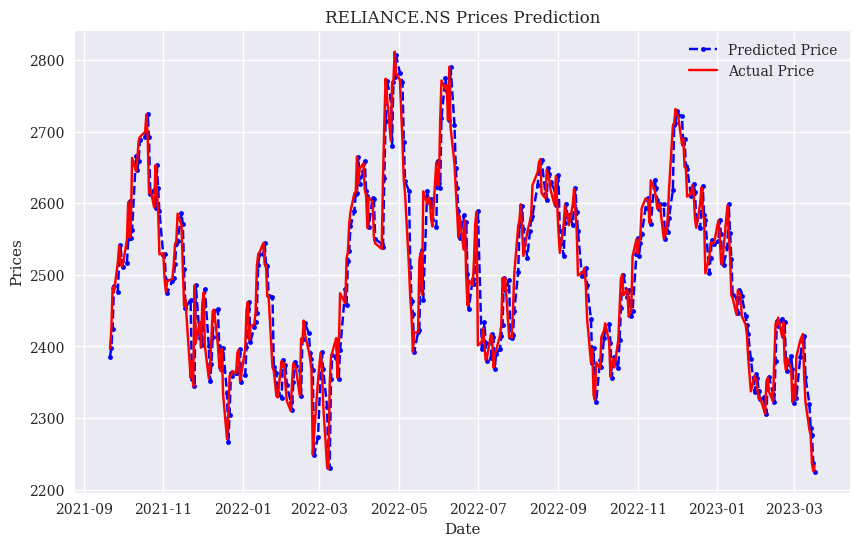

In [53]:
test_set_range = df_close[int(len(df_close)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='.', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('{} Prices Prediction'.format(company_symbol))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [54]:
model = ARIMA(df_close, order=(3,1,0))
model_fit = model.fit()
output = model_fit.forecast()

print('Predicted closing price for today: {}'.format(output[output.keys().start]))

Predicted closing price for today: 2235.1643565176123


/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ashwin/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be g

In [55]:
# Get latest date in stock history data
latest_date = stock_data.index.max()

# Add one day to latest date
latest_date = latest_date + pd.DateOffset(days=1)
latest_date = latest_date.strftime('%Y-%m-%d')

# Update predicted close price to Firestore
predicted_collection = db.collection('predicted_prices')
predicted_collection.document(company_symbol).set({
    latest_date: output[output.keys().start],
}, merge=True)


update_time {
  seconds: 1679041772
  nanos: 579676000
}

#### Model Evaluation

In [56]:
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
arima_mape = np.mean(np.abs(model_predictions - test_data)/np.abs(test_data))

# Print MAPE percentage limited to 4 decimal places
print('MAPE {:.4f}%'.format(arima_mape*100))

Testing Mean Squared Error is 1649.1066906086976
MAPE 1.2269%


## Vanilla LSTM  

In [283]:
stock_data = fin_stock_history.copy()
stock_data['Date'] =  stock_data['Date'].dt.date
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,positive_sentiment,negative_sentiment,neutral_sentiment
0,2018-03-19,873.435875,879.155382,864.711233,868.104126,5829127,0.0,0.0,[],[],"[0.9281095862388612, 0.8758390545845032, 0.934..."
1,2018-03-20,865.971444,876.344121,859.912617,862.578491,7011559,0.0,0.0,[0.9453160762786864],[0.8563583493232727],"[0.8434631824493408, 0.9447512626647948, 0.680..."
2,2018-03-21,867.474007,874.744551,865.971410,869.461243,6791028,0.0,0.0,[],[],"[0.7686998248100281, 0.930237889289856, 0.5450..."
3,2018-03-22,868.588792,884.050839,868.346473,880.367126,10212863,0.0,0.0,[],[],[]
4,2018-03-23,863.353967,872.466427,861.899870,866.553040,10831400,0.0,0.0,[],[],"[0.708733320236206, 0.9338114857673644, 0.8849..."


In [284]:
df_fin = stock_data

# Calculate average sentiment scores for each day
for i,r in df_fin.iterrows():
    df_fin.at[i,'positive_sentiment'] = np.mean(r['positive_sentiment'])
    df_fin.at[i,'negative_sentiment'] = np.mean(r['negative_sentiment'])
    df_fin.at[i,'neutral_sentiment'] = np.mean(r['neutral_sentiment'])

df_fin.fillna(0, inplace=True)
df_fin.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,positive_sentiment,negative_sentiment,neutral_sentiment
1232,2023-03-13,2329.000000,2344.000000,2275.000000,2284.500000,5894088,0.0,0.0,0.819692,0.805432,0.606659
1233,2023-03-14,2280.000000,2304.949951,2269.050049,2275.949951,7396699,0.0,0.0,0.818479,0.731260,0.882431
1234,2023-03-15,2284.100098,2298.300049,2227.399902,2237.050049,10027725,0.0,0.0,0.754049,0.000000,0.818963
1235,2023-03-16,2243.000000,2254.000000,2202.199951,2225.899902,8474595,0.0,0.0,0.801617,0.968355,0.830608
1236,2023-03-17,2244.750000,2251.949951,2212.699951,2233.250000,5405261,0.0,0.0,0.000000,0.000000,0.579350


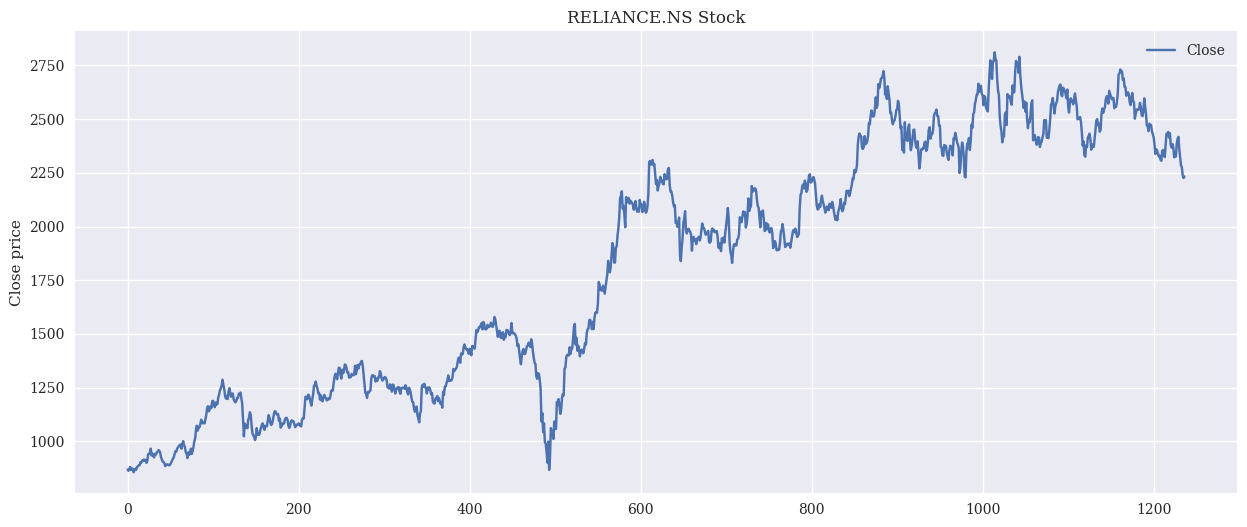

In [285]:

df_fin[['Close']].plot(figsize=(15, 6))
plt.ylabel("Close price")
plt.title("{} Stock".format(company_symbol))
plt.show()

In [286]:
df = df_fin.copy()
df_fin=df_fin[['Close']]
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1237 non-null   float64
dtypes: float64(1)
memory usage: 9.8 KB


In [287]:
#
df=df.fillna(method='ffill')

In [288]:
df_fin=df_fin.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_fin['Close'] = scaler.fit_transform(df_fin['Close'].values.reshape(-1,1))

In [289]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_fin, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (942, 59, 1)
y_train.shape =  (942, 1)
x_test.shape =  (235, 59, 1)
y_test.shape =  (235, 1)


In [290]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [291]:
y_train.size(),x_train.size()

(torch.Size([942, 1]), torch.Size([942, 59, 1]))

In [292]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.attention = nn.Linear(hidden_dim, 1)


    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        attention_scores = self.attention(out)
        attention_weights = torch.softmax(attention_scores, dim=1)
        attention_vector = torch.sum(attention_weights * out, dim=1)

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (attention): Linear(in_features=32, out_features=1, bias=True)
)
12
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
torch.Size([1, 32])
torch.Size([1])


In [293]:
# Train model
#####################
num_epochs = 300
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Should skip if LSTM is to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.055011652410030365
Epoch  20 MSE:  0.019289344549179077
Epoch  30 MSE:  0.006454607006162405
Epoch  40 MSE:  0.004288501106202602
Epoch  50 MSE:  0.003760158084332943
Epoch  60 MSE:  0.0028138435445725918
Epoch  70 MSE:  0.0025971175637096167
Epoch  80 MSE:  0.0024053542874753475
Epoch  90 MSE:  0.002285292837768793
Epoch  100 MSE:  0.0021953806281089783
Epoch  110 MSE:  0.0021174324210733175
Epoch  120 MSE:  0.002048886613920331
Epoch  130 MSE:  0.0019916899036616087
Epoch  140 MSE:  0.0019410859094932675
Epoch  150 MSE:  0.0018908942583948374
Epoch  160 MSE:  0.0018402504501864314
Epoch  170 MSE:  0.0017890994204208255
Epoch  180 MSE:  0.0017370817949995399
Epoch  190 MSE:  0.0016839868621900678
Epoch  200 MSE:  0.0016297585098072886
Epoch  210 MSE:  0.0015744679840281606
Epoch  220 MSE:  0.001518398872576654
Epoch  230 MSE:  0.001462184707634151
Epoch  240 MSE:  0.0014069682219997048
Epoch  250 MSE:  0.0013544661924242973
Epoch  260 MSE:  0.0013065991224721074
Epoc

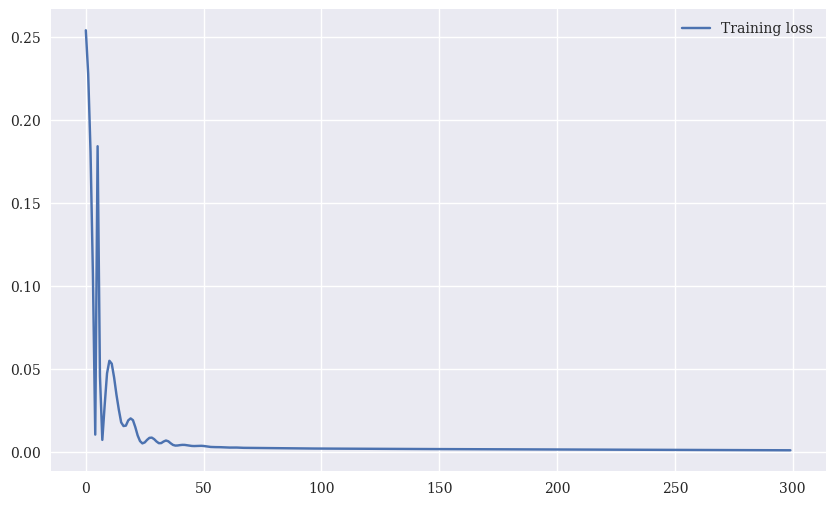

In [294]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [295]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())


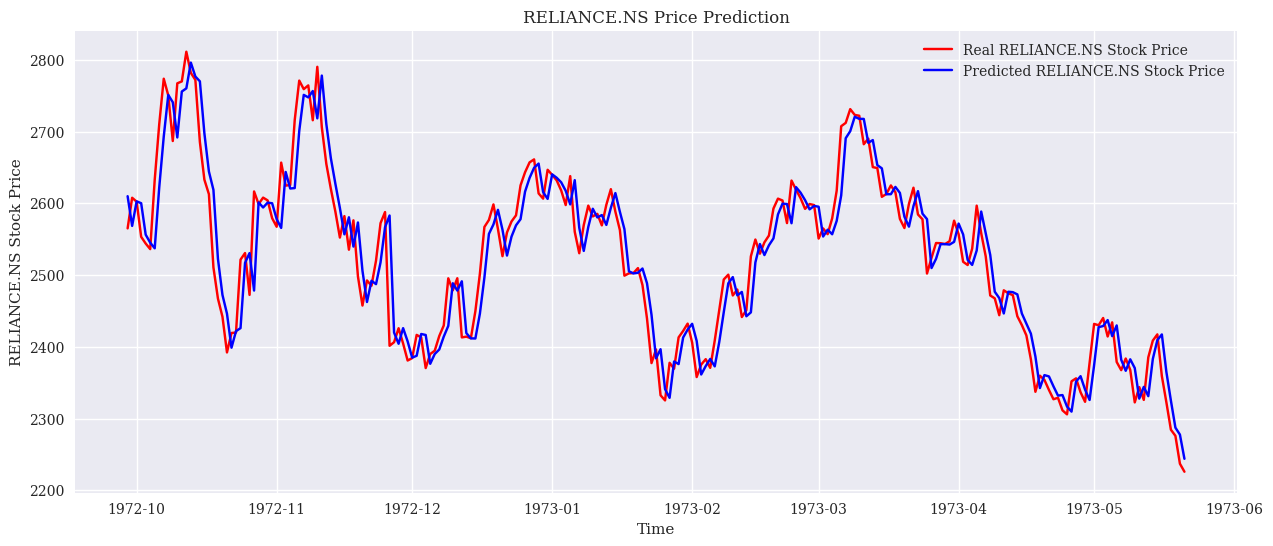

In [296]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_fin[len(df_fin)-len(y_test):].index, y_test, color = 'red', label = 'Real {} Stock Price'.format(company_symbol))
axes.plot(df_fin[len(df_fin)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted {} Stock Price'.format(company_symbol))
#axes.xticks(np.arange(0,394,50))
plt.title('{} Price Prediction'.format(company_symbol))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(company_symbol))
plt.legend()
plt.show()

### Evaluation

In [297]:
MSE_error = mean_squared_error(y_test, y_test_pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))
vlstm_mape = np.mean(np.abs(y_test_pred - y_test)/np.abs(y_test))
print('MAPE: {:.3f}%'.format(vlstm_mape*100))

Testing Mean Squared Error is 1599.322265625
MAPE: 1.196%


## LSTM <> Attention - With news sentiments


In [359]:
df = fin_stock_history.copy()

# Calculate average sentiment scores for each day
for i,r in df.iterrows():
    df.at[i,'positive_sentiment'] = np.mean(r['positive_sentiment'])
    df.at[i,'negative_sentiment'] = np.mean(r['negative_sentiment'])
    df.at[i,'neutral_sentiment'] = np.mean(r['neutral_sentiment'])



In [430]:
# df['Date'] =  df['Date'].dt.date
df.fillna(0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,positive_sentiment,negative_sentiment,neutral_sentiment
0,2018-03-19,0.005081,0.005412,0.006044,0.006345,0.077496,0.0,0.0,0.000000,0.000000,0.954822
1,2018-03-20,0.001319,0.003992,0.003551,0.003519,0.095670,0.0,0.0,0.997891,0.880006,0.863186
2,2018-03-21,0.002076,0.003184,0.006699,0.007039,0.092280,0.0,0.0,0.000000,0.000000,0.824006
3,2018-03-22,0.002638,0.007886,0.007933,0.012615,0.144874,0.0,0.0,0.000000,0.000000,0.000000
4,2018-03-23,0.000000,0.002033,0.004583,0.005552,0.154381,0.0,0.0,0.000000,0.000000,0.906009


In [437]:
df.to_csv('stock_sentiment.csv', index=False)

### Preparing input and output

In [403]:
# define the columns to use for input and output
input_cols = ['Open', 'High', 'Low', 'Volume', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment']
output_col = 'Close'

In [404]:
# normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df[input_cols + [output_col]] = scaler.fit_transform(df[input_cols + [output_col]])

# define the number of timesteps to use for each input sequence
sequence_length = 30

In [405]:
# create input sequences and corresponding output sequences
X = []
y = []
for i in range(sequence_length, len(df)):
    X.append(df[input_cols][i-sequence_length:i].values)
    y.append(df[output_col][i])
X = np.array(X)
y = np.array(y)

In [406]:
# split the data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

In [407]:
# define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_scores = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_scores, dim=1)
        attention_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.linear1(attention_vector)
        out = torch.relu(out)
        out = self.linear2(out)
        return out

In [431]:
# define the hyperparameters
input_size = len(input_cols)
hidden_size = 128
num_layers = 2
lr = 0.001
batch_size = 32
num_epochs = 80

# create the model and optimizer
model = LSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


### Training model

In [432]:
# train the model
for epoch in range(num_epochs):
    permutation = torch.randperm(X_train.shape[0])
    for i in range(0, X_train.shape[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]
        optimizer.zero_grad()
        output = model(torch.tensor(batch_X, dtype=torch.float))
        loss = criterion(output.squeeze(), torch.tensor(batch_y, dtype=torch.float))
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_output = model(torch.tensor(X_val, dtype=torch.float))
        val_loss = criterion(val_output.squeeze(), torch.tensor(y_val, dtype=torch.float))
        if (epoch+1) % 5 == 0:
            print('Epoch: {}/{}  Train Loss: {:.6f}  Val Loss: {:.6f}'.format(epoch+1, num_epochs, loss.item(), val_loss.item()))

Epoch: 5/80  Train Loss: 0.001805  Val Loss: 0.005846
Epoch: 10/80  Train Loss: 0.002536  Val Loss: 0.005009
Epoch: 15/80  Train Loss: 0.001120  Val Loss: 0.003994
Epoch: 20/80  Train Loss: 0.001474  Val Loss: 0.004188
Epoch: 25/80  Train Loss: 0.002721  Val Loss: 0.005333
Epoch: 30/80  Train Loss: 0.000993  Val Loss: 0.009986
Epoch: 35/80  Train Loss: 0.003269  Val Loss: 0.014193
Epoch: 40/80  Train Loss: 0.005058  Val Loss: 0.012033
Epoch: 45/80  Train Loss: 0.001516  Val Loss: 0.017067
Epoch: 50/80  Train Loss: 0.000849  Val Loss: 0.010115
Epoch: 55/80  Train Loss: 0.000292  Val Loss: 0.006630
Epoch: 60/80  Train Loss: 0.001416  Val Loss: 0.002424
Epoch: 65/80  Train Loss: 0.000133  Val Loss: 0.001942
Epoch: 70/80  Train Loss: 0.000155  Val Loss: 0.003626
Epoch: 75/80  Train Loss: 0.001296  Val Loss: 0.007061
Epoch: 80/80  Train Loss: 0.000576  Val Loss: 0.001514


In [433]:
# Make predictions
y_train_pred = model(torch.tensor(X_train, dtype=torch.float)).detach().numpy()
y_val_pred = model(torch.tensor(X_val, dtype=torch.float)).detach().numpy()

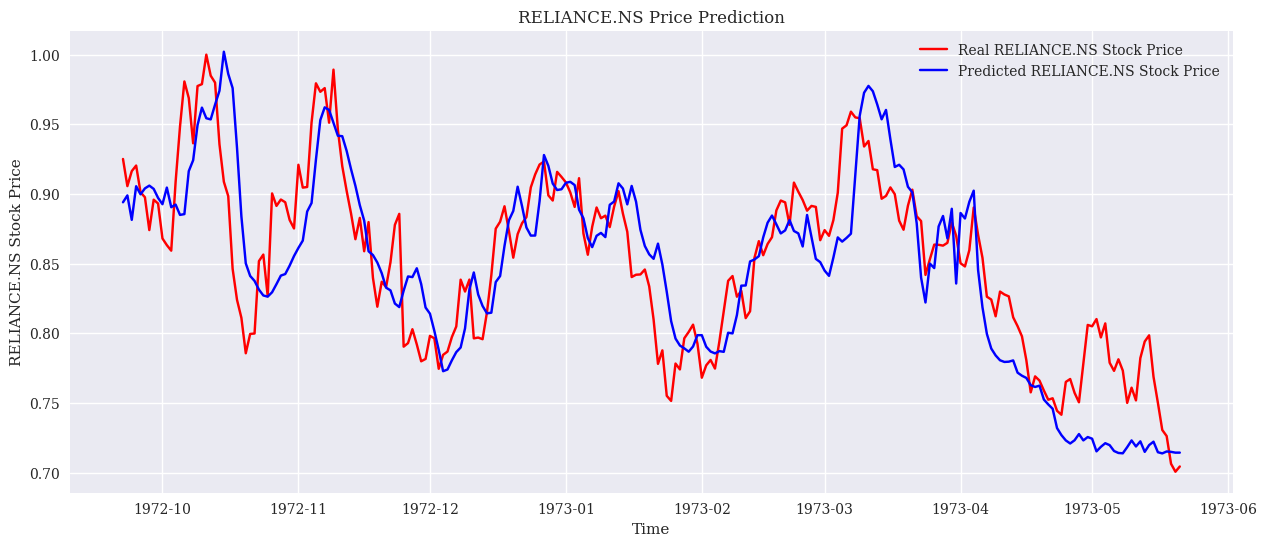

In [434]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_val):].index, y_val, color = 'red', label = 'Real {} Stock Price'.format(company_symbol))
axes.plot(df[len(df)-len(y_val):].index, y_val_pred, color = 'blue', label = 'Predicted {} Stock Price'.format(company_symbol))
#axes.xticks(np.arange(0,394,50))
plt.title('{} Price Prediction'.format(company_symbol))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(company_symbol))
plt.legend()
plt.show()



In [435]:
# # invert predictions
# y_train_pred = scaler.inverse_transform(y_train_pred)
# y_train = scaler.inverse_transform(y_train.detach().numpy())
# y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
# y_test = scaler.inverse_transform(y_test.detach().numpy())


### Evaluation

In [436]:
# Print MAPE and MSE
y_pred = model(torch.tensor(X_val, dtype=torch.float)).detach().numpy()
y_true = y_val
MSE_error = mean_squared_error(y_true, y_pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))
lstm_attn_mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: {:.4f}%'.format((lstm_attn_mape*100)))


Testing Mean Squared Error is 0.0015138486569571433
MAPE: 8.9232%


## Comparison

[1.1962225660681725, 1.2268764825340883, 2.41, 3.92, 17.678163249547147]


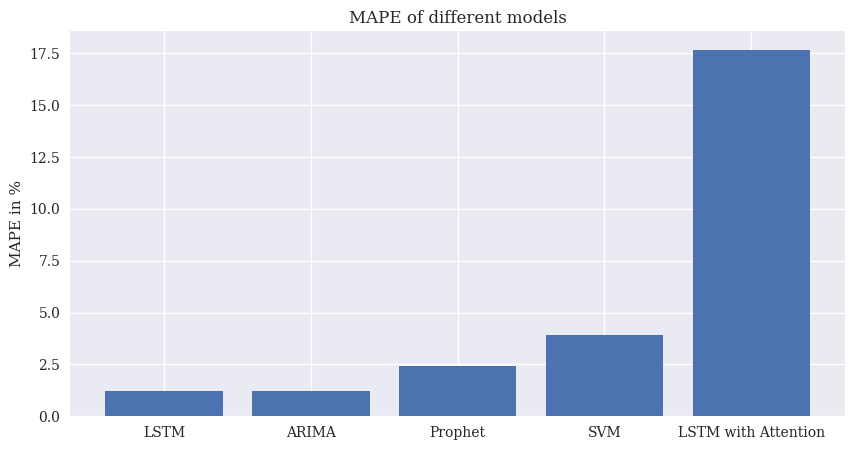

In [427]:
# Plot comparison
mape = [ vlstm_mape,arima_mape, 0.0241, 0.0392, lstm_attn_mape]

# Multiply all values in mape by 100
mape = [i * 100 for i in mape]
print(mape)
models = ['LSTM', 'ARIMA','Prophet', 'SVM', 'LSTM with Attention']
plt.figure(figsize=(10, 5))
plt.bar(models, mape)
plt.title('MAPE of different models')
# plt.xlabel('Models')
plt.ylabel('MAPE in %')
plt.savefig('mape_result.png')
plt.show()

## Testing new code here

In [449]:
import torch.nn.functional as F

class StockPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, output_size):
        super(StockPredictionModel, self).__init__()
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.attention = nn.Linear(hidden_size*self.num_directions, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
    
    def forward(self, ohlc, news):
        lstm_out, _ = self.lstm(ohlc)
        lstm_out = self.dropout(lstm_out)
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        attention_out = torch.sum(lstm_out * attention_weights, dim=1)
        # attention_out = attention_out.unsqueeze(1)
        combined = torch.cat((attention_out, news), dim=1)
        output = self.fc(combined)
        return output

In [450]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,positive_sentiment,negative_sentiment,neutral_sentiment
0,2018-03-19,0.005081,0.005412,0.006044,0.006345,0.077496,0.0,0.0,0.000000,0.000000,0.954822
1,2018-03-20,0.001319,0.003992,0.003551,0.003519,0.095670,0.0,0.0,0.997891,0.880006,0.863186
2,2018-03-21,0.002076,0.003184,0.006699,0.007039,0.092280,0.0,0.0,0.000000,0.000000,0.824006
3,2018-03-22,0.002638,0.007886,0.007933,0.012615,0.144874,0.0,0.0,0.000000,0.000000,0.000000
4,2018-03-23,0.000000,0.002033,0.004583,0.005552,0.154381,0.0,0.0,0.000000,0.000000,0.906009


In [451]:
# Split the data into train and test sets
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Normalize the OHLC and news sentiment data
ohlc_scaler = MinMaxScaler()
ohlc_data = ohlc_scaler.fit_transform(train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits']])
news_scaler = MinMaxScaler()
news_data = news_scaler.fit_transform(train_df[['positive_sentiment', 'negative_sentiment', 'neutral_sentiment']])

# Convert the data to PyTorch tensors
ohlc_tensor = torch.tensor(ohlc_data, dtype=torch.float32)
news_tensor = torch.tensor(news_data, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['Close'].values, dtype=torch.float32)

# Create a DataLoader for the training data
train_dataset = torch.utils.data.TensorDataset(ohlc_tensor, news_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [452]:
# Set the model hyperparameters
input_size = 7 # OHLC data has 7 features
hidden_size = 64
num_layers = 2
dropout = 0.2
bidirectional = True
output_size = 1 # predict the closing price of the stock

# Instantiate the model
model = StockPredictionModel(input_size, hidden_size, num_layers, dropout, bidirectional, output_size)

# Set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (ohlc_batch, news_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(ohlc_batch, news_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))

# Evaluate the model on the test set
ohlc_test = ohlc_scaler.transform(test_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits']])
news_test = news_scaler.transform(test_df[['positive_sentiment', 'negative_sentiment', 'neutral_sentiment']])
ohlc_test_tensor = torch.tensor(ohlc_test, dtype=torch.float32)
news_test_tensor = torch.tensor(news_test, dtype=torch.float32)
y_test_tensor = torch.tensor(test_df['Close'].values, dtype=torch.float32)
with torch.no_grad():
    y_pred_test = model(ohlc_test_tensor, news_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print('Test Loss: {:.4f}'.format(test_loss.item()))

Attn  torch.Size([32, 1])  news  torch.Size([32, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4 and 128x1)